In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-cyber/spam.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction,model_selection,naive_bayes,metrics,svm
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#libraries for text processing
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize ,sent_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/spam-cyber/spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Select only the columns 'v1' and 'v2' and rename them
df = df[['v1', 'v2']].rename(columns={'v1': 'type', 'v2': 'message'})

# Display the first few rows to verify the result
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


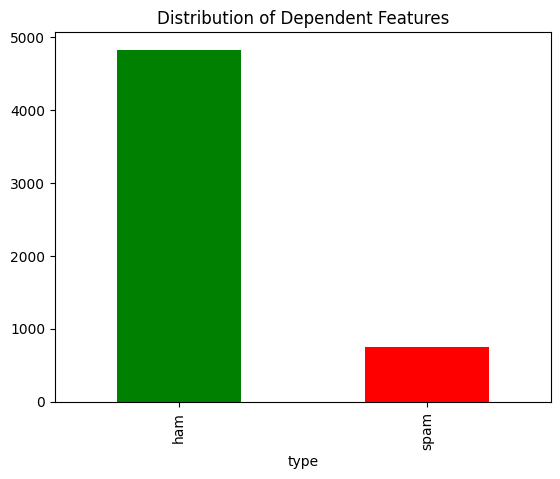

In [5]:
freq = pd.value_counts(df['type'],sort=True)
freq.plot(kind='bar',color=['green','red'])
plt.title('Distribution of Dependent Features')
plt.show()

**SENTENCE CLEANING**

In [6]:
def clean_tokenized_sentence(s):
    """Performs basic cleaning of a sentence"""
    cleaned_s = "" #create empty string to store processed sentence
    words = nltk.word_tokenize(s)
    for word in words:
        #convert to lowercase
        c_word = word.lower()
        #remove punctuations
        c_word = re.sub(r'[^\w\s]','',c_word)
        #remove stopwords
        if c_word != '' and c_word not in stopwords.words('english'):
            cleaned_s = cleaned_s + " " + c_word #append processed words to new list
    return (cleaned_s.strip())

In [9]:
df['cleaned_message'] = df['message'].apply(clean_tokenized_sentence)

NO NLP USING AS MESSAGE MIGHT BE IN MULTIPLE LANGUAGES

In [8]:
df.head(10)

,type,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goes usf lives around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling 3 week word back like fun ...
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,spam,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,spam,Had your mobile 11 months or more? U R entitle...,mobile 11 months u r entitled update latest co...


**Data Exploration to show which words are occuring most freq in non-spam**

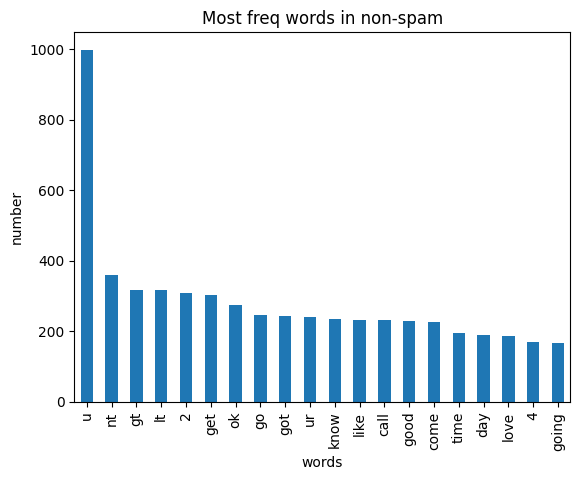

In [10]:
counter_ham = Counter(" ".join(df[df['type']=='ham']['cleaned_message']).split()).most_common(20)
df_ham = pd.DataFrame.from_dict(counter_ham)
df_ham = df_ham.rename(columns={0:"Words in non-spam" ,1: "count"})

df_ham.plot.bar(legend=False)
y_pos = np.arange(len(df_ham["Words in non-spam"]))
plt.xticks(y_pos,df_ham['Words in non-spam'])
plt.title("Most freq words in non-spam")
plt.xlabel("words")
plt.ylabel("number")
plt.show()

In [11]:
df_ham.head()

,Words in non-spam,count
0,u,998
1,nt,359
2,gt,318
3,lt,316
4,2,309


**Data Exploration to show which words are occuring most freq in spam**

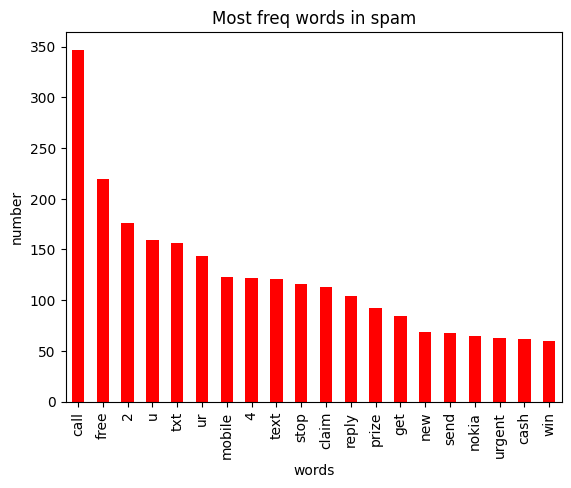

In [12]:
counter_spam = Counter(" ".join(df[df['type']=='spam']['cleaned_message']).split()).most_common(20)
df_spam = pd.DataFrame.from_dict(counter_spam)
df_spam = df_spam.rename(columns={0:"Words in spam" ,1: "count"})

df_spam.plot.bar(legend=False , color='red')
y_pos = np.arange(len(df_spam["Words in spam"]))
plt.xticks(y_pos,df_spam['Words in spam'])
plt.title("Most freq words in spam")
plt.xlabel("words")
plt.ylabel("number")
plt.show()

In [13]:
df_spam.head()

,Words in spam,count
0,call,347
1,free,219
2,2,176
3,u,159
4,txt,156


**Bring data into linear features**

In [14]:
f = feature_extraction.text.CountVectorizer()
X = f.fit_transform(df['cleaned_message'])

In [15]:
df['type'] = df['type'].map({'spam':1,"ham":0})

X_train,X_test,y_train,y_test = train_test_split(X,df['type'],test_size=0.25,random_state=42)


In [16]:
X_train.shape

(4179, 9059)

In [17]:
X_test.shape

(1393, 9059)

**make a performace dict and then check for every algorithm and which performs best**

In [18]:
perf = {}

perf['algorithm_name'] = []
perf['cv_score_f1'] = []
perf['cv_std_f1'] = []

**1)Decision Tree Classifier**

In [19]:
clf = DecisionTreeClassifier(max_depth=5)
cv_scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5,scoring='f1')

In [20]:
perf['algorithm_name'].append('Decision Trees')
perf['cv_score_f1'].append(round(cv_scores.mean()*100,1))
perf['cv_std_f1'].append(round(cv_scores.std(),2))

**2)Random Forest Classifier**

In [21]:
clf = RandomForestClassifier(max_depth=20,n_estimators=50)
cv_scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5,scoring='f1')

In [22]:
perf['algorithm_name'].append('Random Forest Classifier')
perf['cv_score_f1'].append(round(cv_scores.mean()*100,1))
perf['cv_std_f1'].append(round(cv_scores.std(),2))

**3)SVC (Linear Kernel)**

In [23]:
clf = SVC(kernel='linear')
cv_scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5,scoring='f1')

In [24]:
perf['algorithm_name'].append('SVC Linear')
perf['cv_score_f1'].append(round(cv_scores.mean()*100,1))
perf['cv_std_f1'].append(round(cv_scores.std(),2))

**3)SVC ( RBF Kernel)**

In [25]:
clf = SVC(kernel='rbf')
cv_scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=5,scoring='f1')

In [26]:
perf['algorithm_name'].append('SVC RBF')
perf['cv_score_f1'].append(round(cv_scores.mean()*100,1))
perf['cv_std_f1'].append(round(cv_scores.std(),2))

**CHECK RESULTS OF ALL 4 MODELS**

<BarContainer object of 4 artists>

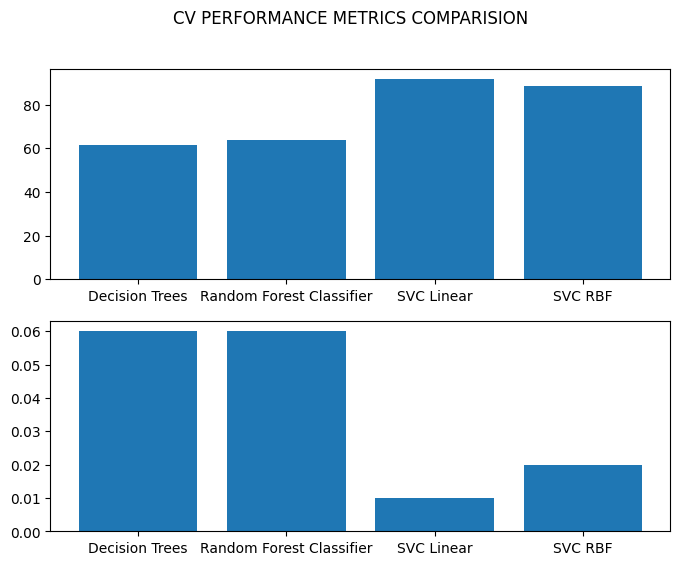

In [27]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
fig.suptitle('CV PERFORMANCE METRICS COMPARISION')

ax1.bar(perf['algorithm_name'],perf['cv_score_f1'])
ax2.bar(perf['algorithm_name'],perf['cv_std_f1'])

Above is MEAN ACCURACY -> higher the better

Below is STD -> lower the better as low vairance

****AS LINEAR IS GETTING BEST , LETS PREDICT DATA ON THAT ****

In [28]:
svc= SVC(kernel='linear')
svc.fit(X_train,y_train)
y_predict = svc.predict(X_test)

In [29]:
metrics.f1_score(y_test,y_predict)

0.8997134670487107

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1202
           1       0.99      0.82      0.90       191

    accuracy                           0.97      1393
   macro avg       0.98      0.91      0.94      1393
weighted avg       0.98      0.97      0.97      1393



In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_predict)

array([[1201,    1],
       [  34,  157]])